In [8]:
import io
import os

import pandas as pd
import numpy as np

from keras import callbacks
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.backend import clear_session
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from PIL import Image
from livelossplot import PlotLossesKeras

In [9]:
image_size = 100
target_size = (image_size, image_size)
image_shape = (image_size, image_size, 1)

datacsv = pd.read_csv('airbnb-listings.csv', sep=';', low_memory=False)
data = datacsv.query('`Number of Reviews` > 20').query('`Review Scores Value` > 9.0').query(
    '`Room Type` == "Entire home/apt"')
indexes = data.index.to_list()
final = data['Price'][indexes]

imlist = []

for file in os.listdir('D:/Pictures2/Train'):
    temp = ['D:/Pictures2/Train/' + str(file), final[int(file[:-4])]]
    imlist.append(temp)

TrainDataframe = pd.DataFrame(imlist, columns=['Image Data', 'Price'])
TrainDataframe = TrainDataframe.dropna()
imlist = []

for file in os.listdir('D:/Pictures2/Test'):
    temp = ['D:/Pictures2/Test/' + str(file), final[int(file[:-4])]]
    imlist.append(temp)

TestDataframe = pd.DataFrame(imlist, columns=['Image Data', 'Price'])
TestDataframe = TestDataframe.dropna()

scaler = MinMaxScaler()
TrainDataframe['Price'] = scaler.fit_transform(TrainDataframe[['Price']])
TestDataframe['Price'] = scaler.transform(TestDataframe[['Price']])

datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_dataframe(dataframe=TrainDataframe, x_col='Image Data', y_col='Price',
                                              class_mode='raw', target_size=target_size, batch_size=10,
                                              color_mode='grayscale', scaler='bicubic')
test_generator = datagen.flow_from_dataframe(dataframe=TestDataframe, x_col='Image Data', y_col='Price',
                                             class_mode='raw', target_size=target_size, batch_size=10,
                                             color_mode='grayscale', scaler='bicubic')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size


Found 19787 validated image filenames.
Found 5104 validated image filenames.


In [33]:
clear_session()
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(48, (5, 5), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(48, (5, 5), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D())
#model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 48)        38448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 48)        57648     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 48)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 5, 64)         

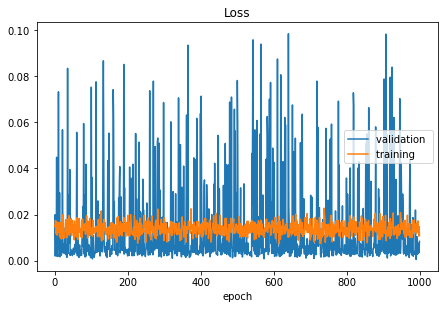

Loss
	validation       	 (min:    0.001, max:   12.911, cur:    0.008)
	training         	 (min:    0.006, max:    0.108, cur:    0.011)


In [40]:
model.compile(optimizer='nadam', loss='mean_squared_error')

history = model.fit_generator(generator=train_generator, steps_per_epoch=50,
                              validation_data=test_generator,
                              validation_steps=50, epochs=1000, callbacks=[PlotLossesKeras()])


In [42]:
model.save('newmodel.h5')
#from keras.utils import plot_model
#plot_model(model, to_file='model.png', show_shapes=True)

In [41]:
# Use to test
# scaler.inverse_transform(model.predict(np.expand_dims(image.img_to_array(image.load_img('D:/Pictures2/Test/277.jpg', target_size=target_size, color_mode='grayscale')), axis=0)))[0][0]
def a(price):
    print('Predicted Price: ' + str(scaler.inverse_transform(model.predict(np.expand_dims(image.img_to_array(
        image.load_img('D:/Pictures2/Test/' + str(price) + '.jpg', target_size=target_size, color_mode='grayscale')),
        axis=0)))[0][0]))
    print('Real price: ' + str(final[price]))
a(209)
a(277)
a(844)
a(1224)
a(1280)
a(1281)
a(1374)
a(1394)
a(1410)
a(1661)
a(1959)
a(2225)
scaler.inverse_transform([[.005]])[0][0]

Predicted Price: 222.0089
Real price: 92.0
Predicted Price: 137.57367
Real price: 156.0
Predicted Price: 137.57367
Real price: 175.0
Predicted Price: 160.94794
Real price: 145.0
Predicted Price: 215.09792
Real price: 45.0
Predicted Price: 137.57358
Real price: 99.0
Predicted Price: 137.57367
Real price: 35.0
Predicted Price: 183.17157
Real price: 35.0
Predicted Price: 137.57367
Real price: 51.0
Predicted Price: 137.57367
Real price: 150.0
Predicted Price: 137.57367
Real price: 65.0
Predicted Price: 165.22404
Real price: 125.0


18.925

In [29]:
#from keras.utils import plot_model
#plot_model(model, show_shapes=True)